# Generalizability to Sub-length of L60 for L100 Classifier

**Author:** Kaiyuan Yang and Olafs Vandans<br>
**Date created:** 2024/04/08<br>
**Last modified:** 2024/04/14<br>
**Description:** Showcase the generalizability of L100 classifier to identify knots in sublength polymer L60.
This tutorial reproduces the Figure 7 (left panel) from the publication "Identifying knot types of polymer conformations by machine learning" [PhysRevE.101.022502](https://journals.aps.org/pre/abstract/10.1103/PhysRevE.101.022502)

## Table of Contents

1. [Introduction](#Introduction)
2. [Setup](#Setup)
3. [Pre-processing](#Pre-processing)
    - [Load dataset from text files](#Load-the-dataset-from-text-files)
    - [Visualize polymer knots](#Visualize-some-polymer-knots)
    - [Normalize xyz to relative positions](#Normalize-the-xyz-coordinate-to-relative-positions)
4. [Load the best trained LSTM model](#Load-the-Best-Trained-LSTM-Model)
5. [Predict on L60 Testset](#Predict-on-L60-Testset)
    - [Confusion matrix and other metrics](#Confusion-matrix-and-other-metrics)

## Introduction

This notebook loads the best weights for a trained model on `L100`, and predicts on unseen new conformations with **a different length**.

The unseen new test data are polymers of length 60 (L60) of 5 different knot types (`knot 0`, `knot 31`, `knot 41`, `knot 52`, and `knot 51`). Each knot type has 200K polymer conformations. Each conformation is represented as a txt file of 3D xyz coordinates.

We implement our networks using `Keras` with a `Tensorflow 2` backend and GPU support.
The model was trained using the polymer length of `L100`.
The model that achieve the best performance (`best_models/temp_20191103-175055_L100_2M_0-31-41-52-51-relative_BiLSTM240BiLSTM200Dp20BiLSTM180BiLSTM180BiLSTM100_.h5`) on the validation set during training were saved later for evaluation on test data.

RNN models accept sequence
inputs of any length. Our LSTM-based RNN model from
Fig. 6(b) of our PRE paper, trained on `Lpolymer = 100` is, without any modification, capable of ingesting polymer conformations of
`Lpolymer = 60`. We have tested it and compiled the results of our trials in confusion matrices in Fig. 7 of the publication. The LSTM-based RNN model is able to predict with accuracy above 98%
for length `Lpolymer = 60`.

<img src="assets/Fig7_L100trained_predictL60.png" alt="Fig7_L100trained_predictL60" width="35%"/>

This shows the generalization of the RNN model trained with `Lpolymer = 100 (L100)` to identify knots in sublength polymers, `Lpolymer = 60 (L60)`, i.e., data of different length than the training
data.


By the end of this tutorial notebook, you will be able to generate the same confusion matrix as Fig. 7 for predicting the `L60` polymers. 

Let's get right into it!

## Setup

In [1]:
import numpy as np
from tqdm.auto import tqdm

# for file path
from glob import glob

# for plotting
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl

# for prediction metrics
from sklearn.metrics import confusion_matrix, balanced_accuracy_score

%matplotlib notebook

In [2]:
# tensorflow, keras, and GPU
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K
from tensorflow.keras import models


### Configs for TF

print("TF version: ", tf.version.VERSION)
print("gpu_available = ", tf.test.is_gpu_available())

# clear previous keras session
K.clear_session()

config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
sess = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(sess)  # set this TensorFlow session as the default session for Keras

# for TF2 dynamic growth of GPU memory
# Allow memory growth for the GPU
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

TF version:  2.4.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
gpu_available =  True


In [3]:
# L60
chain_length = 60
# five knot types
num_knot_types = 5
# 200K conformations per knot type
dataset_size = 200000

# folder with the conformation text files
base_dir = "/tf/data/L60_Lp4_D9_circular_knot"

# L60 200K generated Oct 31st 2019
knot0_folder = base_dir + "0/"
knot31_folder= base_dir + "31/"
knot41_folder = base_dir + "41/"
knot52_folder = base_dir + "52/"
knot51_folder = base_dir + "51/"

print(">>> will use length L{}, loading data from {}"\
      .format(chain_length, knot31_folder))

>>> will use length L60, loading data from /tf/data/L60_Lp4_D9_circular_knot31/


## Pre-processing

Load the `L60_Lp4_D9_circular_knot*` folders containing L60 multiclass knots,

```
chain_0_1.txt
...
chain_52_135981.txt
chain_52_171991.txt
...
```

as numpy arrays. And normalize the xyz coordinates into relative positions to feed into the model.

### Load the dataset from text files

In [4]:
# glob(path) will return a list of file names
(cat0, cat1, cat2, cat3, cat4) = (
    glob(knot0_folder + "chain_0*"),
    glob(knot31_folder + "chain_31*"),
    glob(knot41_folder + "chain_41*"),
    glob(knot52_folder + "chain_52*"),
    glob(knot51_folder + "chain_51*"))

assert len(cat0) == len(cat1) == len(cat2) == len(cat3)
assert len(cat3) == len(cat4) == dataset_size

In [5]:
# test_x_files = list of file names of
# chain_0, chain_31, chain_41, chain_52, chain_51 file names
test_x_files = np.array(cat0 + cat1 + cat2 + cat3 + cat4)

# test_y = list of 0-4:
# 0 is for chain_0, 1 is for chain_31, 2 is for chain_41
# 3 is for chain_52, 4 is for chain_51
test_y = np.array(
    [0] * dataset_size +
    [1] * dataset_size +
    [2] * dataset_size +
    [3] * dataset_size +
    [4] * dataset_size)

print("test_x_files is list of file names: ", test_x_files[:3], test_x_files[-3:])
print("test_y should be list of 0 1 2... ints's: ", test_y)
print(">>>")
print("test_x_files shape: ", test_x_files.shape)
print("test_y shape: ", test_y.shape)

assert len(test_x_files) == dataset_size*num_knot_types
assert len(test_x_files) == len(test_y)

test_x_files is list of file names:  ['/tf/data/L60_Lp4_D9_circular_knot0/chain_0_59966.txt'
 '/tf/data/L60_Lp4_D9_circular_knot0/chain_0_195102.txt'
 '/tf/data/L60_Lp4_D9_circular_knot0/chain_0_76745.txt'] ['/tf/data/L60_Lp4_D9_circular_knot51/chain_51_73530.txt'
 '/tf/data/L60_Lp4_D9_circular_knot51/chain_51_144580.txt'
 '/tf/data/L60_Lp4_D9_circular_knot51/chain_51_97901.txt']
test_y should be list of 0 1 2... ints's:  [0 0 0 ... 4 4 4]
>>>
test_x_files shape:  (1000000,)
test_y shape:  (1000000,)


**Load the xyz coordinate values from text files as array for input to the model**

this step will take a few minutes

In [6]:
# use float32 with loadtxt
test_x = np.array([np.loadtxt(f, dtype=np.float32) for f in tqdm(test_x_files, mininterval=1)])

print("test_x.shape is: ", test_x.shape)


test_x.shape is:  (1000000, 60, 3)


### Verify the input and labels

In [7]:
print(test_x.shape, test_y.shape)
print(test_x.dtype, test_y.dtype)

# input x shape
assert test_x.shape[1:] == (chain_length, 3)

# xyz always start at origin 0
assert np.sum(test_x[9999][0]) == 0
assert np.sum(test_x[1000][0]) == 0

(1000000, 60, 3) (1000000,)
float32 int64


### Visualize some polymer knots

In [8]:
def plot_conformation(datas):
    """ 
    the data comes in as:
    (chain length = num rows in data file) x (xyz dimensions)
    
    Plots a list of input strands on matplotlib Axes3D 
    """
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    for data in datas:
        # [:, 0] takes the first column
        xs = data[:,0]
        # Your colouring array
        T=np.linspace(0,1,np.size(xs))**2
        #  print(np.size(xs))
        #  print(T)
        #  print(np.size(T))
        ys = data[:,1]
        zs = data[:,2]
        # Segement plot and colour depending on T
        s = 1 # Segment length
        n = len(xs)
        for i in range(0,n,s):
            ax.plot(
                xs[i:i+s+1],
                ys[i:i+s+1],
                zs=zs[i:i+s+1],
                color=(T[n-i-1],T[i],T[i]),
                linewidth=2.0
            )
        #  ax.plot(xs, ys, zs=zs, color=(0.0,0.5,T[0]))
        ax.set_xlabel('X axis')
        ax.set_ylabel('Y axis')
        ax.set_zlabel('Z axis')
    plt.show()

0
(60, 3)


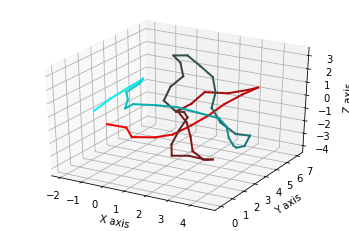

In [9]:
%matplotlib inline

polymer_id = len(cat0)-1

print(test_y[polymer_id])
print(test_x[polymer_id].shape)

plot_conformation([test_x[polymer_id]])

1
(60, 3)


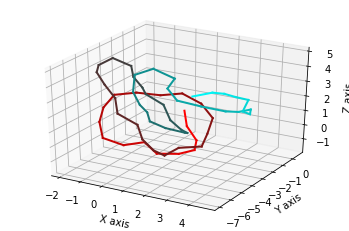

In [10]:
%matplotlib inline

polymer_id = len(cat0)

print(test_y[polymer_id])
print(test_x[polymer_id].shape)

plot_conformation([test_x[polymer_id]])

### Normalize the xyz coordinate to relative positions

The inputs of the conformation for neural networks are deltas in x, y, z, i.e., the changes in monomer positions in the x, y, and z directions at every step.

To improve NN performance, we convert the trajectory of positions to their relative increments from the previous coordinate (Fig. 3). For example, a trajectory of X -coordinates [0, 0.8, 0.5, 1.4, 2.2] is converted
to [+0.8, −0.3, +0.9, +0.8].

Since the bond length, i.e., the distance between two adjacent monomers, is a unit length, this conversion yields an additional benefit of scaling the data in the [0, 1] range, akin to normalization.

In [11]:
test_x = np.diff(test_x, n=1, axis=1)

print("snapshot of test_x[0, :3]: ", test_x[0, :3])

max_test_x, min_test_x = np.max(test_x), np.min(test_x)

print("maxmin for test_x: ", max_test_x, min_test_x)

snapshot of test_x[0, :3]:  [[ 0.67788    -0.07612    -0.73122   ]
 [-0.19472     0.21114999 -0.95787   ]
 [-0.16571     0.47738    -0.86293006]]
maxmin for test_x:  1.0000002 -1.0000002


### Verify the test data before model prediction

In [12]:
assert max_test_x < 1.0000005
assert min_test_x > -1.0000005

# when using diff, chain_length -= 1
assert test_x.shape[1:] == (chain_length -1, 3)
assert test_x.shape[0] == (dataset_size * num_knot_types)

# test for y label
assert test_y.shape == (dataset_size * num_knot_types, )
assert np.count_nonzero(test_y == 1) == np.count_nonzero(test_y == 0)
assert np.count_nonzero(test_y == 1) == np.count_nonzero(test_y == 4)


assert len(test_y) == dataset_size*num_knot_types

assert len(test_x) == len(test_y)

print("data sanity tests passed :)")

data sanity tests passed :)


## Load the Best Trained LSTM Model

Using `keras.models.load_model(save_model_name)`

In [13]:
# Best RNN model:
# Nov03 99.59acc BiLSTM stacks
best_model_dir = "/tf/best_models/"
save_model_name = best_model_dir + \
    "temp_20191103-175055_L100_2M_0-31-41-52-51-relative_BiLSTM240BiLSTM200Dp20BiLSTM180BiLSTM180BiLSTM100_.h5"

print("model to be used: ", save_model_name)

model = keras.models.load_model(save_model_name)

model.summary()

model to be used:  /tf/best_models/temp_20191103-175055_L100_2M_0-31-41-52-51-relative_BiLSTM240BiLSTM200Dp20BiLSTM180BiLSTM180BiLSTM100_.h5
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, None, 240)         119040    
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 200)         272800    
_________________________________________________________________
dropout (Dropout)            (None, None, 200)         0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, None, 180)         209520    
_________________________________________________________________
bidirectional_3 (Bidirection (None, None, 180)         195120    
_________________________________________________________________
bidirectional_4 (Bidirection (None, 100)       

The number of trainable params (889,385) is the same as the one reported in Table 1 of the publication (last row).

## Predict on L60 Testset

With `model.predict_classes()` to generate predicted class.

In [14]:
predictions = model.predict_classes(test_x, batch_size=2048, verbose=1)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


489/489 [==============================] - 33s 63ms/step


### Confusion matrix and other metrics

In [15]:
# balanced_accuracy_score(y_true, y_pred, *[, ...]) Compute the balanced accuracy.
balanced_accuracy_score(test_y, predictions)

0.9924199999999999

In [16]:
confusion_matrix(test_y, predictions)

array([[196868,   2366,    589,    144,     33],
       [   247, 197554,     43,    789,   1367],
       [   157,      5, 199782,     56,      0],
       [    76,    499,     45, 199044,    336],
       [    11,    494,      3,    320, 199172]])

#### Make a pretty confusion matrix plot

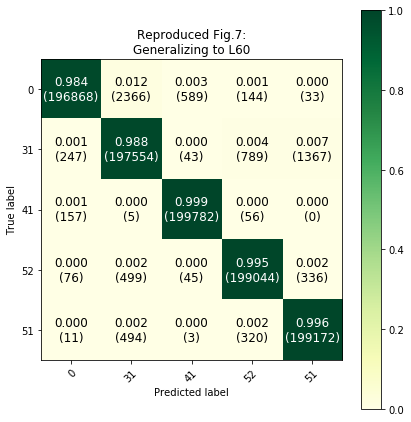

In [17]:
%matplotlib inline

# general settings for the plot
cmap = plt.cm.YlGn
classes = ["0", "31", "41", "52", "51"]

fig, ax = plt.subplots(figsize=(6, 6))

title = 'Reproduced Fig.7:\nGeneralizing to L{}'.format(chain_length)

# Compute confusion matrix
cm = confusion_matrix(test_y, predictions)

abs_num = cm # save a copy of the absolute numbers of the cm

# calculate the percentage divided by the row's sum 
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Set the colormap and norm for colorbar
norm = mpl.colors.Normalize(vmin=0.0, vmax=1.0)
im = ax.imshow(cm, interpolation='nearest', cmap=cmap, norm=norm,)
ax.figure.colorbar(im, ax=ax)
# We want to show all ticks...
ax.set(xticks=np.arange(cm.shape[1]),
        yticks=np.arange(cm.shape[0]),
        ylim=(4.5, -.5),
        # ... and label them with the respective list entries
        xticklabels=classes, yticklabels=classes,
        title=title,
        ylabel='True label',
        xlabel='Predicted label')

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
            rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
fmt = '.3f'
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(
            j, i,
            format(cm[i, j], fmt) + "\n(" + format(abs_num[i, j], 'd') + ")",
            ha="center", va="center", fontsize=12,
            color="white" if cm[i, j] > thresh else "black")

fig.tight_layout()

# Plot normalized confusion matrix
plt.show()

Successfully reproduced the generalizability Fig. 7 (left panel) of the publication!